## Ensemble Learning: Decision Tree Classifier

In [75]:
import pandas as pd
import numpy as np

from collections import Counter
from IPython.display import Image

from utils import cross_validation_split, accuracy_metric, evaluate_algorithm, predict

## Dection Tree

본 튜토리얼에서는 'Decision Tree(의사결정나무)'를 알아본다.

의사결정 나무는 대표적 앙상블 모델인 Random Forest(랜덤 포레스트)의 기본이 되는 모델로, 랜덤 포테스트는 여러 개의 decision tree의 집합(ensemble)이다.

Decision Tree 는 데이터에 내재되어 있는 패턴을 변수의 조합으로 나타내는 모델이고, 분류(classification)와 회귀(regression) 문제에 모두 사용할 수 있다.

질문을 던져서 맞고 틀리는 것에 따라 우리가 생각하는 대상을 향해 다가가고, 이는 '스무고개' 놀이와 비슷하다.

본 튜토리얼에서는 이진 분류(binary classification)을 진행한다

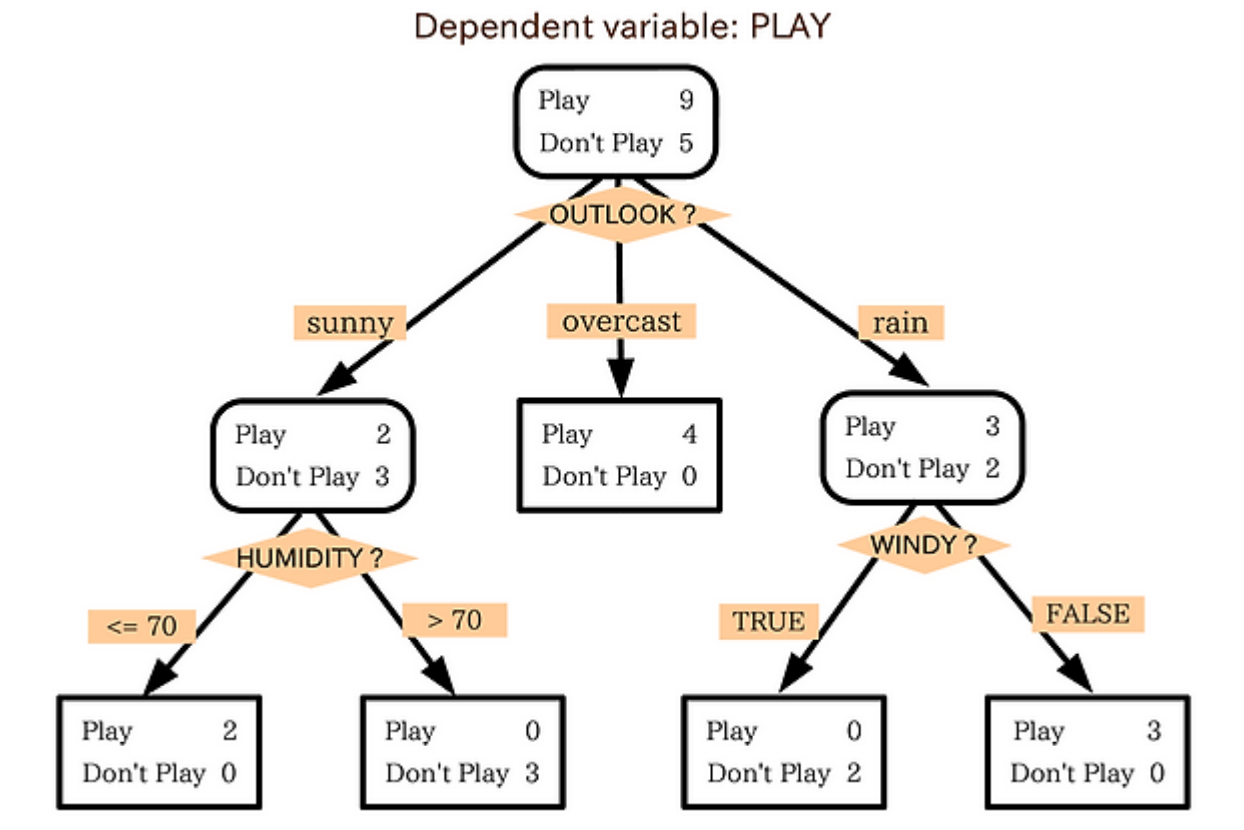

In [76]:
Image('./images/decsion_tree.png')

## Data

본 튜토리얼에서 사용할 데이터는 '와인 데이터'이다

총 13개의 변수를 가지고 있고, 177개의 관측치를 가지고 있다.

Wine 변수는 와인의 종류를 의미하고, 원본 데이터는 총 3개의 label이 존재한다 (1,2,3)

In [77]:
data = pd.read_csv("./data/wine.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wine                  178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic.acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Acl                   178 non-null    float64
 5   Mg                    178 non-null    int64  
 6   Phenols               178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid.phenols  178 non-null    float64
 9   Proanth               178 non-null    float64
 10  Color.int             178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD                    178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [78]:
unique_list = list(np.unique(data['Wine']))
print(f'원본 데이터의 와인 종류는 {unique_list}이다')


원본 데이터의 와인 종류는 [1, 2, 3]이다


종류별 데이터의 수는 다음과 같다.

In [79]:
counter = Counter(data['Wine']).most_common()

for i in range(len(counter)):
    print(f'{counter[i][0]} 종류의 와인은 {counter[i][1]}개 이다')

2 종류의 와인은 71개 이다
1 종류의 와인은 59개 이다
3 종류의 와인은 48개 이다


본 튜토리얼에서는 이진 분류를 진행할 예정이기 때문에, 

가장 많은 2 번 종류의 와인을 제거하고
1 종류 와인 59개와 3종류 와인 48개를 가지고 이진 분류를 진행한다.

In [80]:
data_binary = data[data['Wine']!=2].reset_index(drop=True)
data_binary = data_binary.sample(frac=1)  # row 전체 shuffle
unique_list =list(np.unique(data_binary['Wine']))
print(f'수정된 데이터의 와인 종류는 {unique_list}이다')

수정된 데이터의 와인 종류는 [1, 3]이다


분류를 위해 class 정보를 가진 Wine 변수를 데이터 맨 뒤로 붙여주면, 데이터의 모습은 다음과 같다.

In [81]:
wine_values = data_binary['Wine'].values
data_binary =  data_binary.drop(columns=['Wine']).reset_index(drop=True)
data_binary['Wine'] = wine_values
data_binary

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline,Wine
0,12.79,2.67,2.48,22.0,112,1.48,1.36,0.24,1.26,10.80,0.48,1.47,480,3
1,13.41,3.84,2.12,18.8,90,2.45,2.68,0.27,1.48,4.28,0.91,3.00,1035,1
2,14.10,2.02,2.40,18.8,103,2.75,2.92,0.32,2.38,6.20,1.07,2.75,1060,1
3,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.52,0.56,1.51,675,3
4,13.82,1.75,2.42,14.0,111,3.88,3.74,0.32,1.87,7.05,1.01,3.26,1190,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,13.16,3.57,2.15,21.0,102,1.50,0.55,0.43,1.30,4.00,0.60,1.68,830,3
103,13.48,1.67,2.64,22.5,89,2.60,1.10,0.52,2.29,11.75,0.57,1.78,620,3
104,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
105,13.77,1.90,2.68,17.1,115,3.00,2.79,0.39,1.68,6.30,1.13,2.93,1375,1


마지막으로 데이터 프레임 형태의 데이터를 list 형태로 바꿔준다.

list의 첫 번째 인자로 데이터 프레임의 column 이름을 넣어주고, string을 순차적으로 integer로 변환해준다.

이후 row 별로 list로 변환하여 value_list라는 분석에 사용할 최종의 list를 만들어 준다.

In [82]:
colnames = list(data_binary.columns)
value_list =  []
value_list.append(colnames)

for i in data_binary.values:
    i_list = list(i)
    value_list.append(i_list)

In [83]:
index = 0

for _ in value_list[0]: # _ in colnames
    value_list[0][index] = index
    index += 1
    
print(f'기존 변수인\n{list(data_binary.columns)}을\n{value_list[0]}로 변환한다')

기존 변수인
['Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols', 'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline', 'Wine']을
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]로 변환한다


## Decision Tree from Scratch

### 1. Gini Index

Decision Tree는 지니 계수를 고려해서 분류를 하고 지니 계수는 식과 같다.

그룹의 사이즈를 고려한 지니 계수를 구하는 함수는 다음과 같다 (relative size)

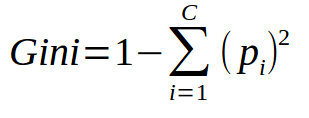

In [84]:
Image('./images/gini.png')

In [85]:
# Calculate the Gini index for a split dataset

def gini_index(groups, classes): # groupt data, classes
	# 모든 변수의 합
	n_instances = float(sum([len(group) for group in groups]))
 
	# Gini 계수 가중합
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# 0으로 나누기 방지
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size # row[-1] = class
			score += p * p
		# 가중합
		gini += (1.0 - score) * (size / n_instances)
	return gini

### 2. Split a Dataset

Decision Tree를 학습할때 모델은 특정 값(value)를 기준으로 데이터를 이진 분할한다. 

In [86]:
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right # left 혹은 right 한 개만 return

split한 지점에서 가장 좋은(지니 계수가 낮은, 지니 계수는 불순도를 의미하기 때문에 낮은게 좋음!) split point 찾기

In [87]:
def get_split(dataset):
    
	class_values = list(set(row[-1] for row in dataset)) # class values = label (1,3)
	b_index, b_value, b_score, b_groups = 999, 999, 999, None # 초기값 설정을 위해 매우 큰 수 할당 
 
	for index in range(len(dataset[0])-1): # label 빼고 변수 수 만큼
		for row in dataset: # 모든 데이터
			groups = test_split(index, row[index], dataset) # 조건에 맞던 left or right return
			gini = gini_index(groups, class_values) # 지니 계수 구하기
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

### 3. Maximum Tree Depth

Decision Tree를 무한정 깊게 만드는 것은 overfitting의 가능성이 있다.

따라서 다음 두 가지 hyperparameter를 통해 terminal node (마지막 node)를 어떻게 구할 것인지 정한다.

Maximum Tree Depth: Decision Tree에서 마지막 노드의 최대 갯수 (설정한 최대 갯수에 도달하면, split을 중지한다)


Minimum Node Records: Decision Tree에서 마지막 노드의 최소 갯수 (설정한 최대 갯수에 도달전까지, split을 계속한다)

In [88]:
# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group] 
	return max(set(outcomes), key=outcomes.count)

### 4. Resursive Spliting 

Decision Tree를 미리 설정한 max_depth에 도달하고, min_size보다 더 split 할때까지 반복한다

In [89]:
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)

### 5. Decision Tree

In [90]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root

def decision_tree(train, test, max_depth, min_size):
	tree = build_tree(train, max_depth, min_size)
	predictions = list()
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
	return(predictions)

### 성능평가

In [91]:
from random import seed

seed(1995)

# load and prepare data
dataset = value_list

# evaluate algorithm
n_folds = 5
max_depth = 5
min_size = 10
scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size) # n_fold validation

print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [100.0, 95.23809523809523, 100.0, 100.0, 95.23809523809523]
Mean Accuracy: 98.095%


 5-fold cross validation을 진행한 결과 높은 성능이 나왔다. binary classification에서는 decision tree가 아직은 유용함을 알 수 있다

### 실험: max_depth 값에 따른 성능변화

In [92]:
for i in [5,10,15,20,25,30]:
    max_depth = i
    scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size) # n_fold validation
    print(f'Max_Depth={max_depth}')
    print('Mean Accuracy: %.3f%%\n' % (sum(scores)/float(len(scores))))

Max_Depth=5
Mean Accuracy: 96.190%

Max_Depth=10
Mean Accuracy: 97.143%

Max_Depth=15
Mean Accuracy: 98.095%

Max_Depth=20
Mean Accuracy: 96.190%

Max_Depth=25
Mean Accuracy: 96.190%

Max_Depth=30
Mean Accuracy: 95.238%



아주 미비했지만 max_depth가 15로 상승하면서 성능이 향상되었다. 

다만 max_depth가 20에 이상으로 도달하면 overfitting으로 인해 성능이 감소하였다.